In [1]:
import os
import numpy as np

from nibabel.testing import data_path
import nibabel as nib

## Defining data path 

- ROOT_DIR: directory of the jupyter-notebook
- DATA_DIR: directory of the nifti data. Must contain as much labels as brain, organized in alphabetical order.

In [2]:
# Global variables
ROOT_DIR = "./"
DATA_DIR = './nifti/'
TRAIN_DATA_PROPORTION = 0.8 # Proportion of data used for training

## Initializing dataset

Getting every \*.nii and their \*-labels.nii into numpy array.

In [3]:
# Input format: (<nom>.nii et <nom>_label.nii)
# Getting all the data files
dataset_data, dataset_labels = [], []
dataset_data_headers, dataset_labels_headers = [], []
i_data, i_label = 0, 0
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        filename = os.path.join(subdir, file)
        if filename.endswith(".nii") and not "nifti_em" in filename:
            # Adding source data into dataset_data
            if not ("-labels" in filename):
                tmp = nib.load(filename)
                dataset_data.append(tmp.get_fdata())
                dataset_data_headers.append(tmp.header)
                print("Added to train data:", i_data,":\t", filename)
                i_data += 1
            # Adding label data into dataset_labels
            else:
                tmp = nib.load(filename)
                dataset_labels.append(tmp.get_fdata())
                dataset_labels_headers.append(tmp.header)
                print("Added to label data:", i_label, ":\t", filename)
                i_label += 1
            
dataset_data = np.array(dataset_data, dtype=np.float32) 
dataset_labels = np.array(dataset_labels, dtype=np.int8)

# Verifying training data is valid
assert(dataset_data.shape == dataset_labels.shape)
print("Dataset shape: ", dataset_data.shape)

Added to train data: 0 :	 ./nifti/506/Shank_506.ibw.nii
Added to label data: 0 :	 ./nifti/506/Shank_506-labels.nii
Added to train data: 1 :	 ./nifti/521/Shank_521.ibw.nii
Added to label data: 1 :	 ./nifti/521/Shank_521-labels.nii
Added to label data: 2 :	 ./nifti/497/Shank_497-labels.nii
Added to train data: 2 :	 ./nifti/497/Shank_497.ibw.nii
Added to label data: 3 :	 ./nifti/496/Shank_496-labels.nii
Added to train data: 3 :	 ./nifti/496/Shank_496.ibw.nii
Added to train data: 4 :	 ./nifti/520/Shank_520.ibw.nii
Added to label data: 4 :	 ./nifti/520/Shank_520-labels.nii
Added to label data: 5 :	 ./nifti/542/Shank_542-labels.nii
Added to train data: 5 :	 ./nifti/542/Shank_542.ibw.nii
Added to label data: 6 :	 ./nifti/550/Shank_550c-labels.nii
Added to train data: 6 :	 ./nifti/550/Shank_550c.ibw.nii
Added to label data: 7 :	 ./nifti/536/Shank_536-labels.nii
Added to train data: 7 :	 ./nifti/536/Shank_536.ibw.nii
Added to label data: 8 :	 ./nifti/499/Shank_499-labels.nii
Added to train data

### 3D Plot visualization tool

Code taken from another group to display a label in 3D.

In [4]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
import matplotlib.pyplot as plt

# Taken from another group's code
def plot3D_label(data):
    data = np.squeeze(data)
    p = data[::1, ::4, ::4].swapaxes(1, 2).swapaxes(0, 2)
    verts, faces, _, values = measure.marching_cubes_lewiner(p, level=0)
    
    fig = plt.figure(figsize=(10, 10))
    ax  = fig.add_subplot(111, projection='3d')
    
    mesh = Poly3DCollection(list(verts[faces]), alpha=0.25, linewidth=0.1)
    edge_color = [0, 0, 0]
    mesh.set_edgecolor(edge_color)
    mesh.set_facecolor('k')
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax.view_init(35, 25)

Display every labels of the dataset in order to make sure the input data is not corrupted.

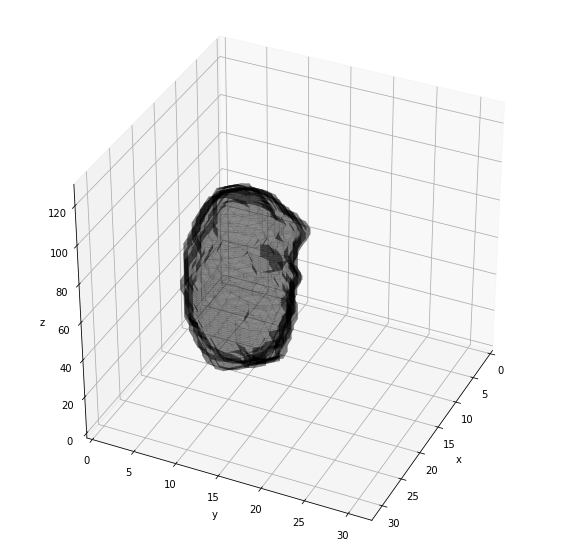

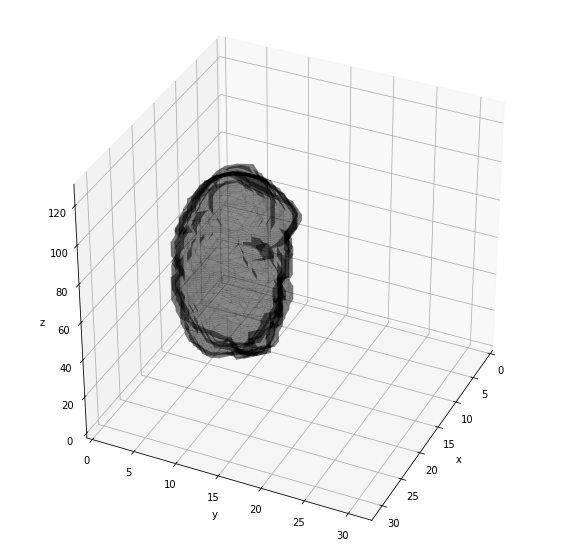

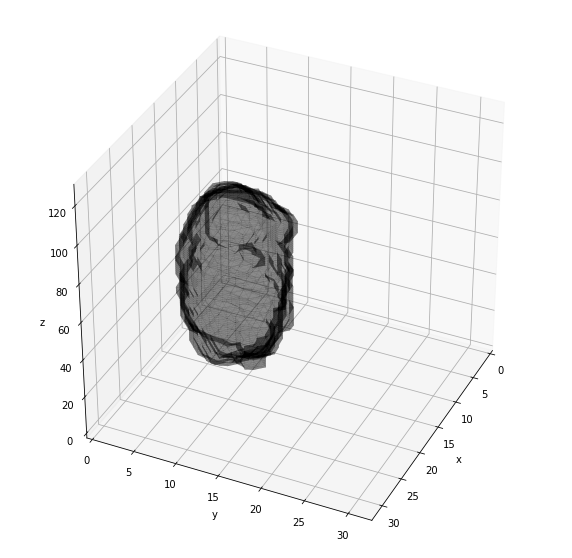

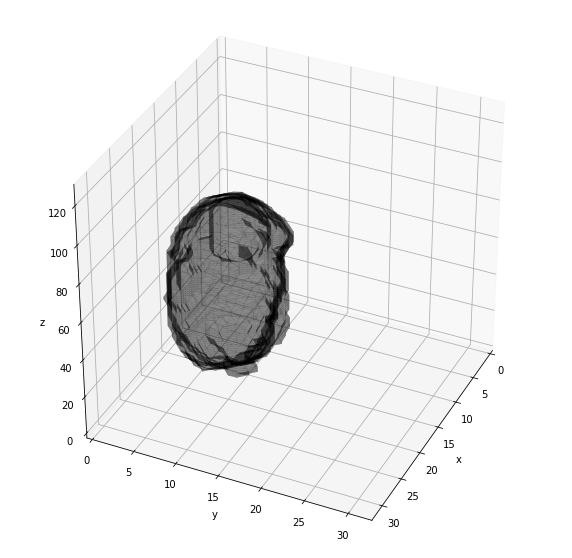

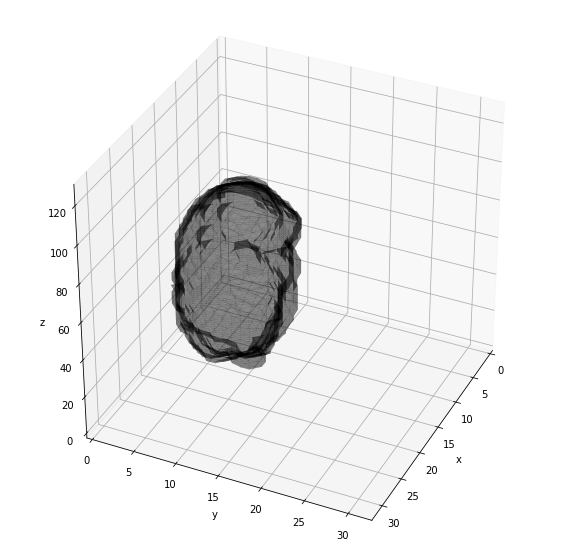

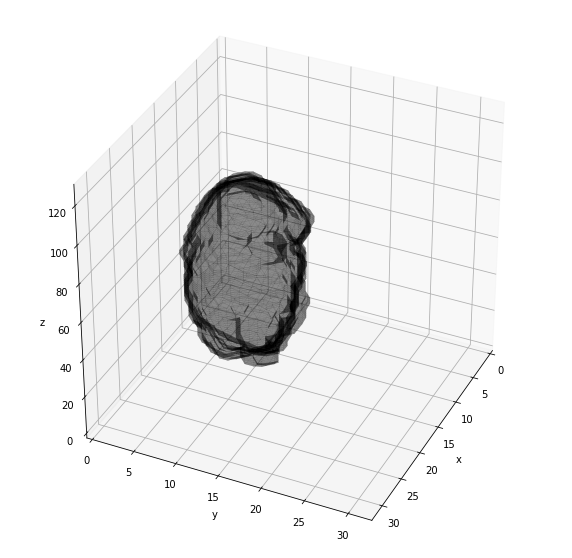

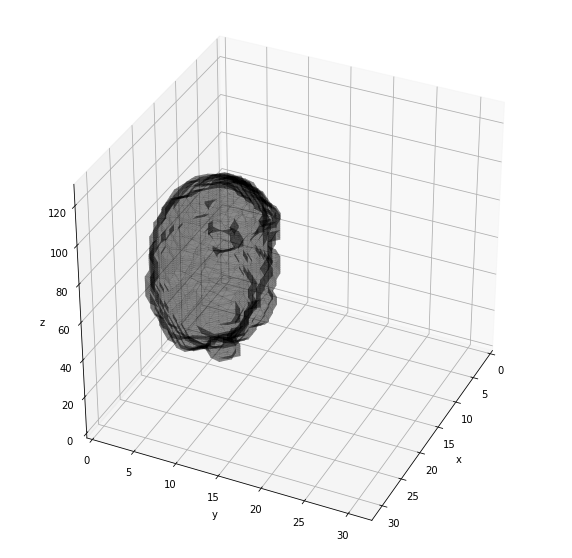

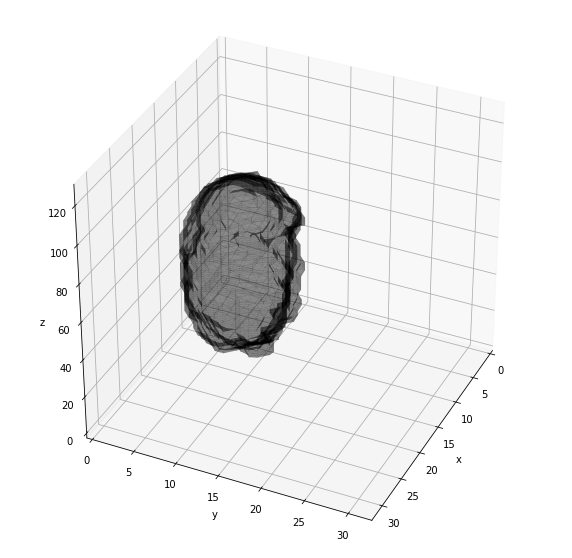

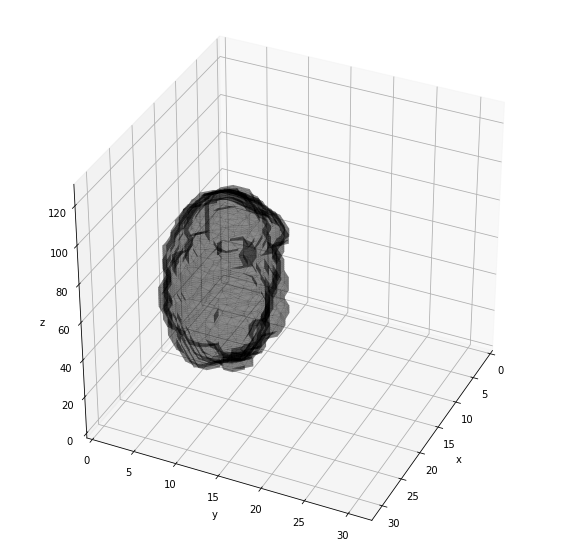

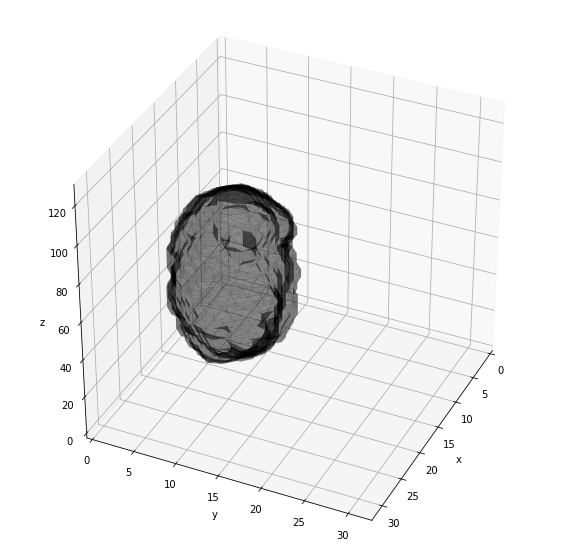

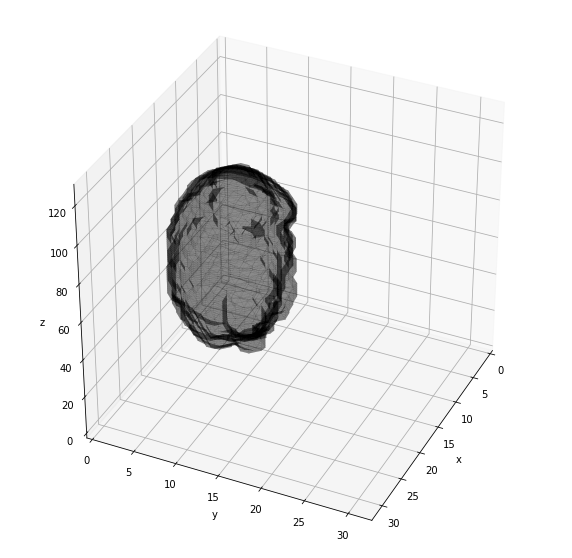

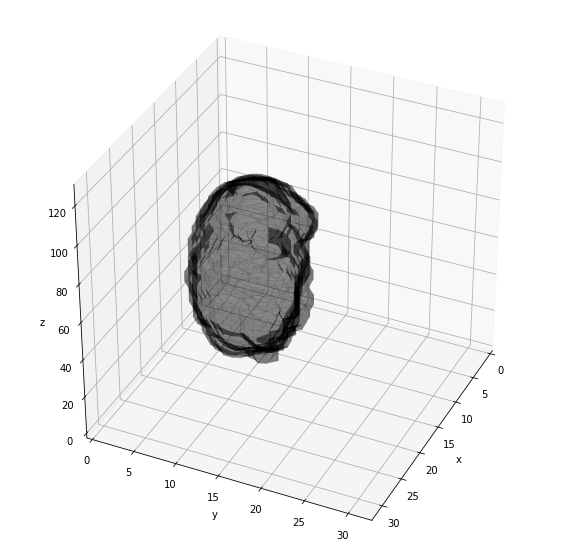

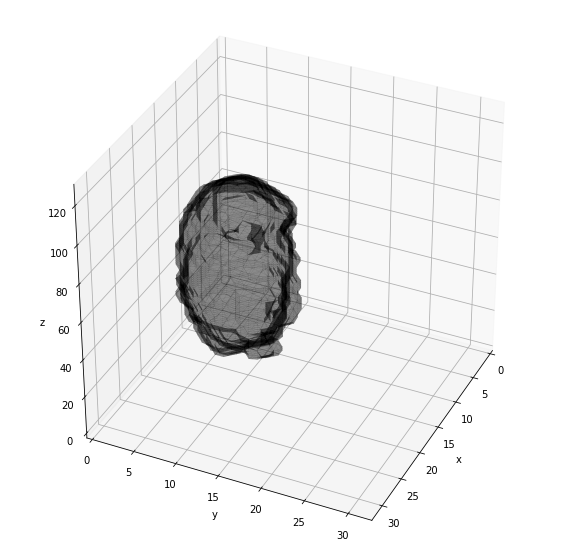

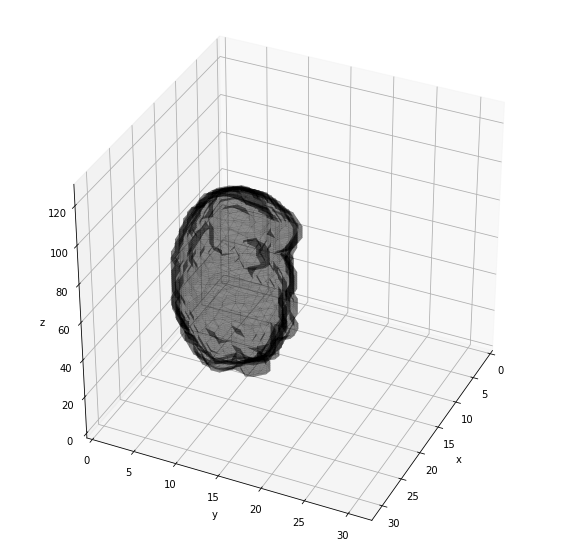

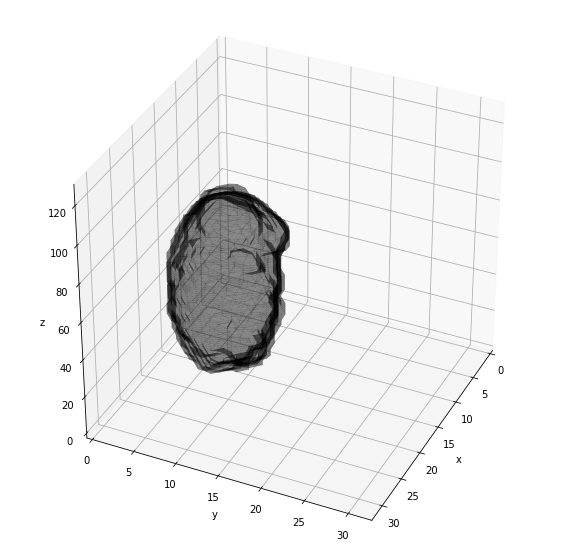

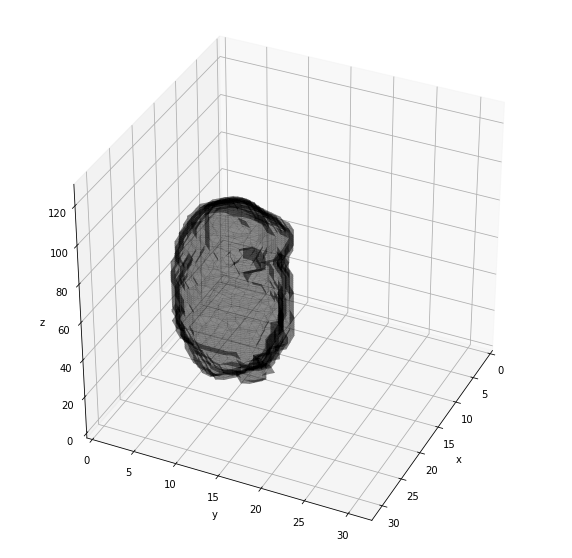

In [5]:
# Displaying 3D brains
for label in dataset_labels:
    plot3D_label(label)

### Splitting dataset and verifying everything works fine

Here, we split the dataset into training and testing data.
We use **TRAIN_DATA_PROPORTION** to decide how much data will be used for training/testing.

Then, we make sure every data is well formated, which means :

- The shape of all sets is the same
- The labels array contains only zeros and ones
- The types of the arrays use a minimal amount of RAM


In [6]:
def splitTrainingData(data, proportion):
    split_index = int(len(data)*proportion)
    tmp = np.split(data, [split_index, len(data)])
    return tmp[0], tmp[1]

In [7]:
# Splitting data into testing and training sets
X_train, X_test  = splitTrainingData(dataset_data, TRAIN_DATA_PROPORTION)
Y_train, Y_test  = splitTrainingData(dataset_labels, TRAIN_DATA_PROPORTION)

# Verifying training data is valid
assert(X_train.shape == Y_train.shape and X_test.shape == Y_test.shape)
print("Training data:", X_train.shape[0], "\nTesting data: ", X_test.shape[0])

Training data: 12 
Testing data:  4


In [8]:
# Printing maximum value for each dataset
shape = Y_train[0].shape
for data in Y_train:
    assert data.shape == shape
for data in Y_test:
    assert data.shape == shape
for data in X_train:
    assert data.shape == shape
for data in X_test:
    assert data.shape == shape
print("All the data has the same shape.")

All the data has the same shape.


In [9]:
print("Data shape:", Y_train[0].shape)
print("Data type of label:", Y_train[0].dtype)
print("Data type of data:", X_train[0].dtype)

Data shape: (128, 128, 128)
Data type of label: int8
Data type of data: float32


In [10]:
# Printing maximum value for each dataset
for data in Y_train:
    print("Max value a data from Y_train:",np.max(data))
for data in Y_test:
    print("Max value a data from Y_test:",np.max(data))

# Function used to set all the 2 labels to 1
def removeUnusedLabels(dataset):
    f = np.vectorize(lambda x: 1 if x == 2. else 0, otypes=[np.int8])
    return f(dataset)

# Remove keep only label 2 of each training data
Y_train = removeUnusedLabels(Y_train)
Y_test  = removeUnusedLabels(Y_test)

# Verifying label data validity
assert np.max(Y_train) == 1., "Y_train has "+str(np.max(Y_train))+", expected 1."
assert np.max(Y_test) == 1., "Y_test has "+str(np.max(Y_test))+", expected 1."
assert(X_train.shape == Y_train.shape and X_test.shape == Y_test.shape)
print("Reformated labels")

Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_test: 2
Max value a data from Y_test: 2
Max value a data from Y_test: 1
Max value a data from Y_test: 2
Reformated labels


RuntimeError: No surface found at the given iso value.

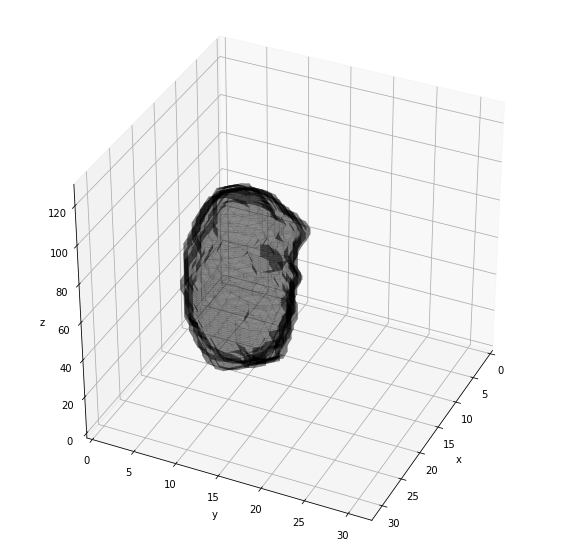

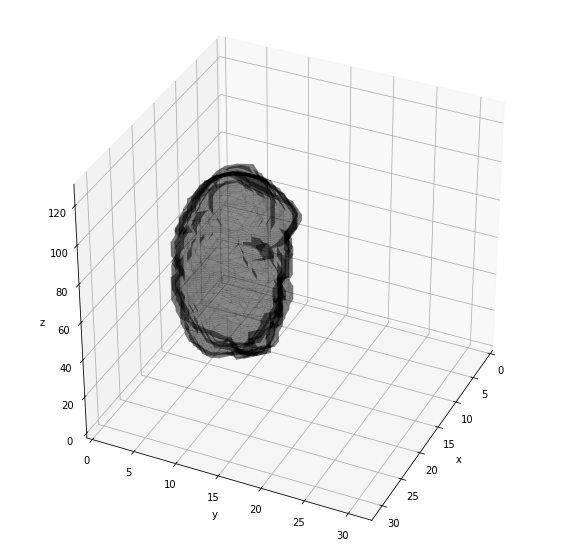

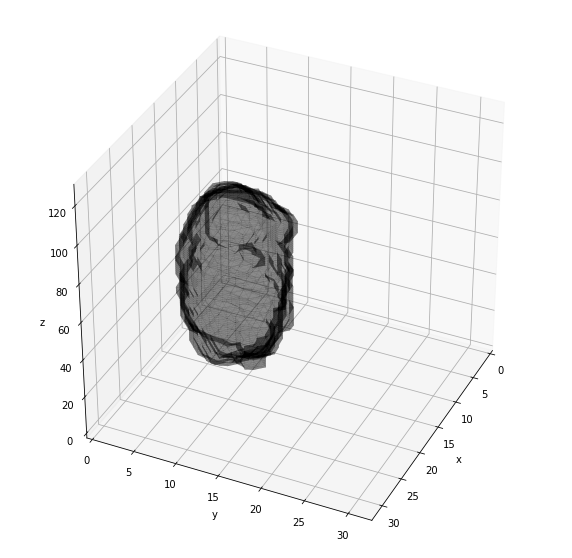

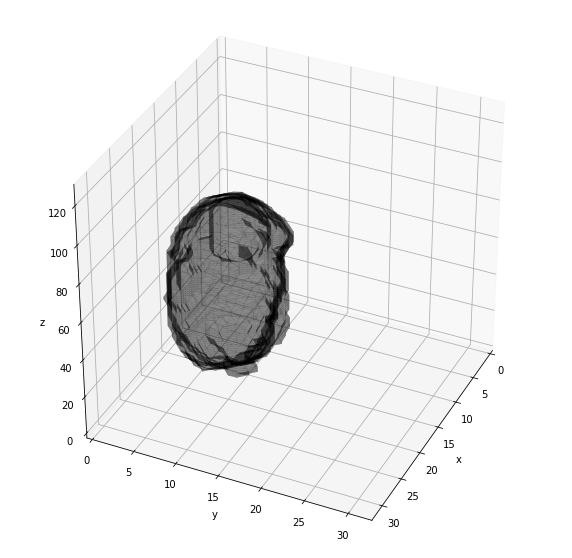

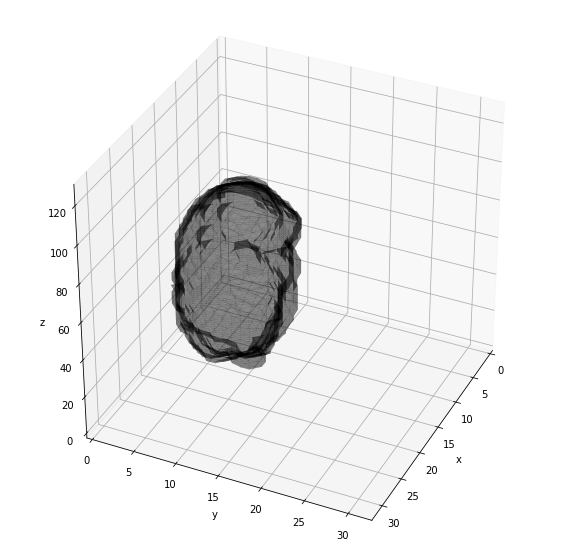

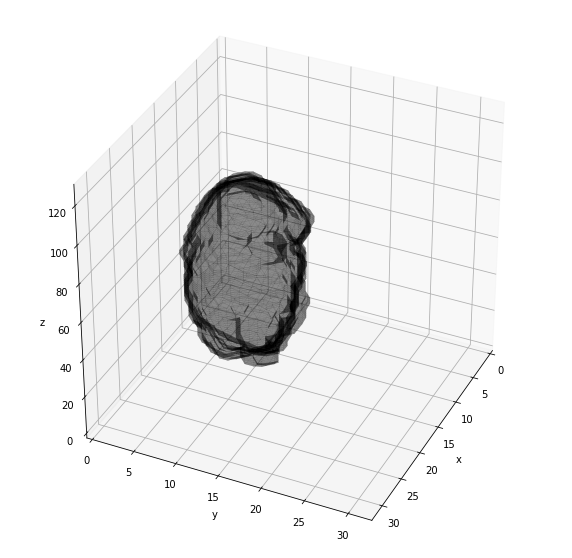

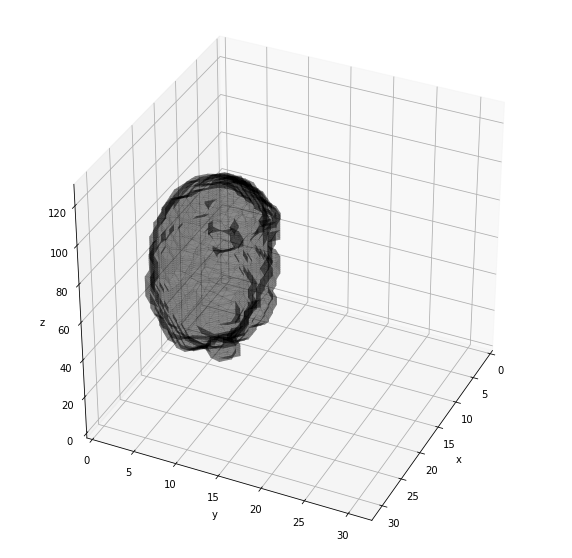

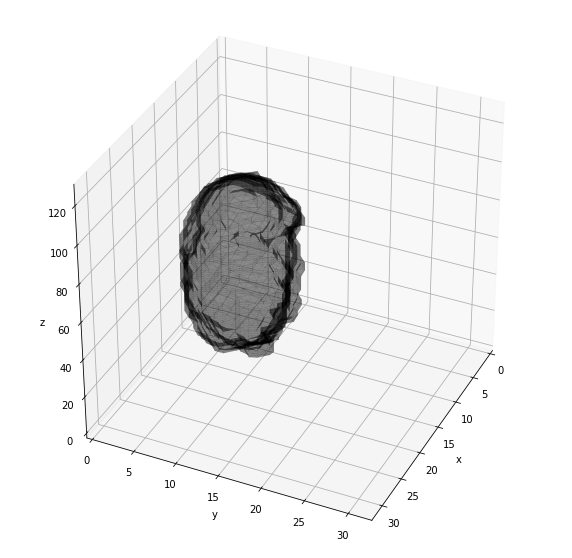

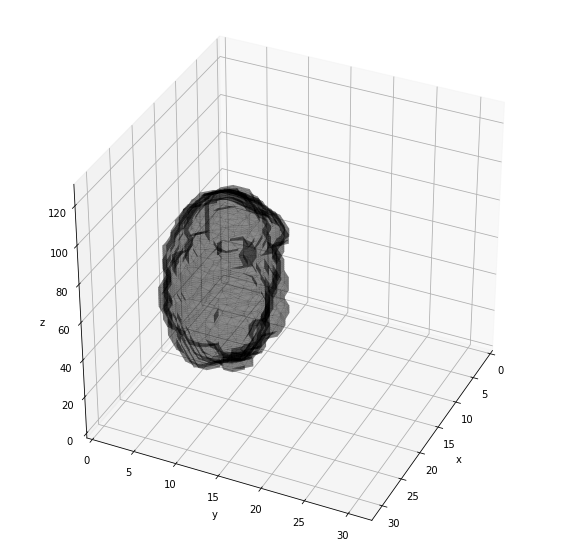

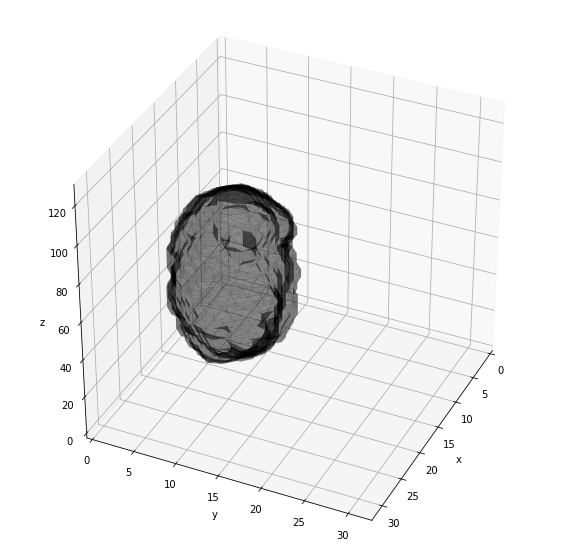

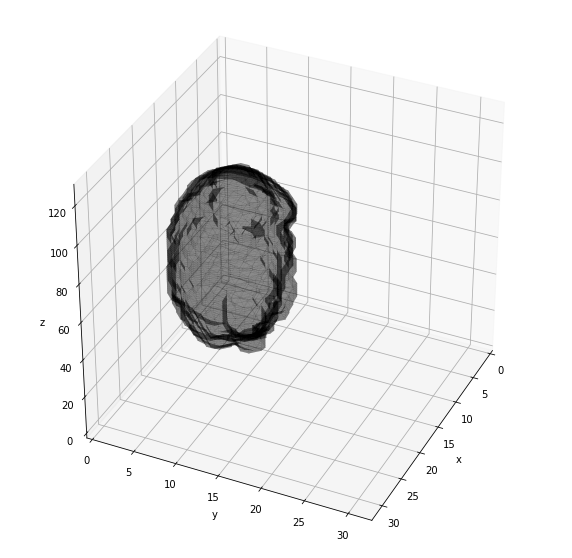

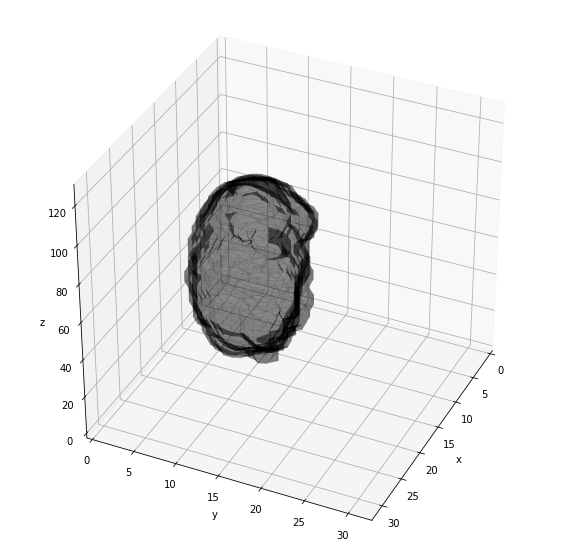

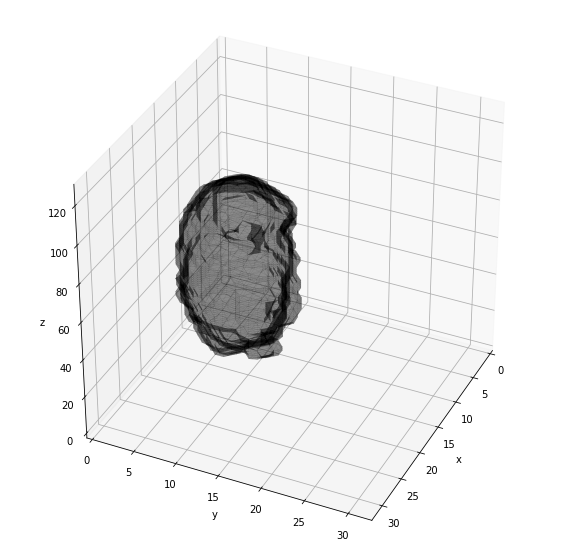

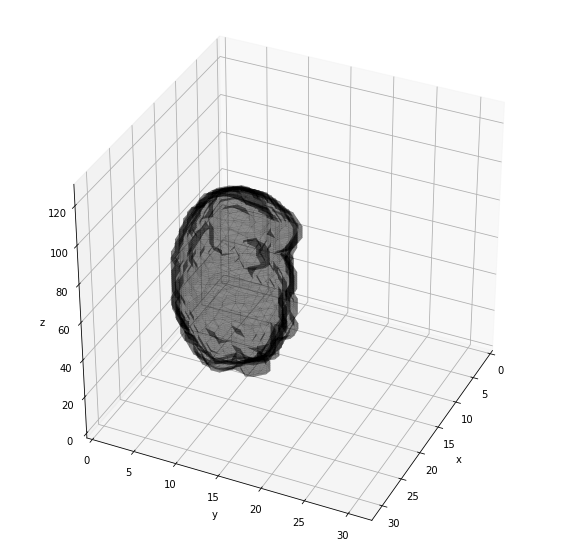

In [11]:
# Displaying 3D brains
for label in np.concatenate((Y_train, Y_test)):
    plot3D_label(label)

# Augmenting dataset

In order to augment dataset, we use a random 3D rotation on each training data.

## How to augment dataset

The choice here is to set the maximum rotation angle to 180 degree, instead of 30 degrees.

This is done to have more data having more differences, and hopefully having a stronger net regarding measure errors.

## Implementation

As a GPU is available, **numba** package has been used. It implements some **numpy** functions in CUDA, to speedup computation. The augmentation of the dataset is VERY long, that is why numba is requiered.

Each training data is rotated 1 time, so there won't be 1 data more present than the others in the resulting training set.

The result of a rotation has been displayed in 3D to make sure the function works, and it does !

Here, there is a big issue of ressources available. Both Google Colab and my own PC don't have enough RAM to run this whole script, so I tried to reduce to the amount of data generated so it can still fit in the RAM. This script has been run and crashed countless times before having a result, which was very frustrating.

In [12]:
import random
import scipy
from scipy.ndimage.interpolation import rotate
from numba import jit

#CUDA version, but scipy.ndimage.interpolation.rotate is not supported
#@cuda.jit
@jit('Tuple((float32[:], int8[:]))(float32[:], int8[:], float32)', parallel = True, fastmath = True, forceobj=True)#, nopython=True)
def random_rotation_3d_cuda(batch1, batch2, max_angle):
    """ Randomly rotate an image by a random angle (-max_angle, max_angle).

    Arguments:
    max_angle: `float`. The maximum rotation angle.

    Returns:
    batch of rotated 3D images
    """
    batch1_rot = np.zeros(batch1.shape, dtype=batch1.dtype)
    batch2_rot = np.zeros(batch2.shape, dtype=batch2.dtype)
    for i in range(batch1.shape[0]):
            image1b1 = batch1[i]
            image1b2 = batch2[i]
            # rotate along z-axis
            angle = random.uniform(-max_angle, max_angle)
            image2b1 = scipy.ndimage.interpolation.rotate(image1b1, angle, mode='nearest', axes=(0, 1), reshape=False)
            image2b2 = scipy.ndimage.interpolation.rotate(image1b2, angle, mode='nearest', axes=(0, 1), reshape=False)

            # rotate along y-axis
            angle = random.uniform(-max_angle, max_angle)
            image3b1 = scipy.ndimage.interpolation.rotate(image2b1, angle, mode='nearest', axes=(0, 2), reshape=False)
            image3b2 = scipy.ndimage.interpolation.rotate(image2b2, angle, mode='nearest', axes=(0, 2), reshape=False)

            # rotate along x-axis
            angle = random.uniform(-max_angle, max_angle)
            batch1_rot[i] = scipy.ndimage.interpolation.rotate(image3b1, angle, mode='nearest', axes=(1, 2), reshape=False)
            batch2_rot[i] = scipy.ndimage.interpolation.rotate(image3b2, angle, mode='nearest', axes=(1, 2), reshape=False)
    return batch1_rot, batch2_rot

# Using np.squeeze outside cuda kernel as it is not supported by numba
def random_rotation_3d(batch1, batch2, max_angle=180.):
    assert batch1.shape == batch2.shape
    size = batch1.shape
    batch1 = np.squeeze(batch1)
    batch2 = np.squeeze(batch2)
    batch1_rot, batch2_rot = random_rotation_3d_cuda(batch1, batch2, max_angle)
    return  batch1_rot.reshape(size), batch2_rot.reshape(size)

# Using multithreading instead of numba
def rotate_one(pid3D1, pid3D2, max_angle):
    image1b1 = pid3D1
    image1b2 = pid3D2
    
    # rotate along z-axis
    angle = random.uniform(-max_angle, max_angle)
    image2b1 = scipy.ndimage.interpolation.rotate(image1b1, angle, mode='nearest', axes=(0, 1), reshape=False)
    image2b2 = scipy.ndimage.interpolation.rotate(image1b2, angle, mode='nearest', axes=(0, 1), reshape=False)

    # rotate along y-axis
    angle = random.uniform(-max_angle, max_angle)
    image3b1 = scipy.ndimage.interpolation.rotate(image2b1, angle, mode='nearest', axes=(0, 2), reshape=False)
    image3b2 = scipy.ndimage.interpolation.rotate(image2b2, angle, mode='nearest', axes=(0, 2), reshape=False)

    # rotate along x-axis
    angle = random.uniform(-max_angle, max_angle)
    return scipy.ndimage.interpolation.rotate(image3b1, angle, mode='nearest', axes=(1, 2), reshape=False), scipy.ndimage.interpolation.rotate(image3b2, angle, mode='nearest', axes=(1, 2), reshape=False)

# On pourrait combler le noir avec du bruit, mais c'est compliqué.

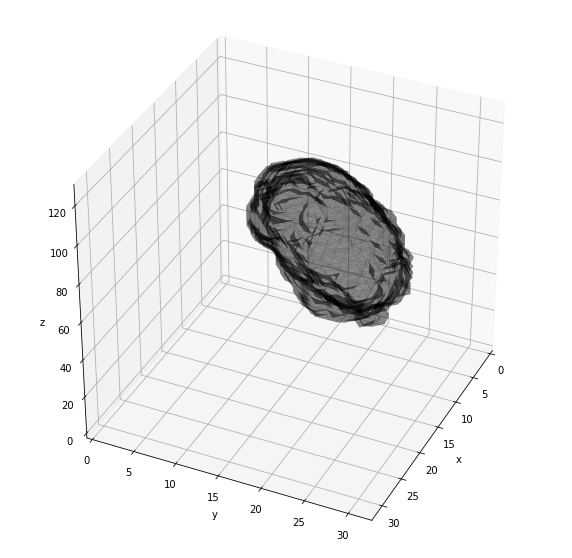

In [13]:
X_train_r, Y_train_r = random_rotation_3d(X_train, Y_train)
assert X_train.shape == X_train_r.shape and Y_train.shape == Y_train_r.shape

plot3D_label(Y_train_r[0])

In [14]:
# Augmenting dataset
maxiter = 25
X_train_bk = X_train
Y_train_bk = Y_train
for i in range(maxiter):
    print (100*i/maxiter, "%", end='\r')
    X_train_r, Y_train_r = random_rotation_3d(X_train_bk, Y_train_bk)
    X_train = np.concatenate((X_train, X_train_r), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_r), axis=0)
print(X_train_bk.shape, X_train.shape)

(12, 128, 128, 128) (312, 128, 128, 128)


# Training a model

## Defining the model

Here, a UNET 3D is used. It has been used because as a human, recognizing a brain in 3D is waaaaaaaayyyyyyy easier than recognizing a brain in 2D without knowing the topology. So, it should be easier for the convolutions too.

A first UNET having around 300,000 parameters has been used, but detected nothing. This may be because input dimension is 128*128*128=2,097,152, and so the net has a too small dimension.

Another UNET having 22,000,000 parameters has been done, but cannot fit in the GPU memory so it hasn't been used.

The last UNET used is the current one, having 1,401,413 parameters. This is still less than the input dimension, but it is the biggest that fits in the GPU memory.

In [15]:
# Reshaping data to fit in the model
X_test  = X_test.reshape((X_test.shape[0], 128,128,128,1))
X_train = X_train.reshape((X_train.shape[0], 128,128,128,1))
Y_test  = Y_test.reshape((Y_test.shape[0], 128,128,128,1))
Y_train = Y_train.reshape((Y_train.shape[0], 128,128,128,1))

In [16]:
#taken from https://github.com/zhixuhao/unet/blob/master/model.py

import skimage.io as io
import skimage.transform as trans
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet3D(pretrained_weights = None, input_size = (128,128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up7 = Conv3D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 4)
    conv7 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 4)
    conv8 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 4)
    conv9 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [17]:
model = unet3D()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 6928        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
NB_EPOCHS = 100
BATCH_SIZE = 1

In [19]:
# Training Model on GPU if available\n",
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device = tf.device('/GPU:0') if tf.test.is_gpu_available() else tf.device('/CPU:0')
print("Using GPU: ", tf.test.is_gpu_available())

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using GPU:  True


In [20]:
with device:
    model.fit(X_train, Y_train,
        epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_test, Y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss')])

Train on 312 samples, validate on 4 samples
Epoch 1/100
312/312 [==============================] - 225s 721ms/sample - loss: 0.0770 - accuracy: 0.9231 - val_loss: 0.0590 - val_accuracy: 0.9410
Epoch 2/100
312/312 [==============================] - 208s 665ms/sample - loss: 0.0769 - accuracy: 0.9231 - val_loss: 0.0590 - val_accuracy: 0.9410
Epoch 3/100
312/312 [==============================] - 208s 666ms/sample - loss: 0.0769 - accuracy: 0.9231 - val_loss: 0.0590 - val_accuracy: 0.9410
Epoch 4/100
312/312 [==============================] - 208s 665ms/sample - loss: 0.0769 - accuracy: 0.9231 - val_loss: 0.0590 - val_accuracy: 0.9410


In [21]:
model.save_weights("model.h5")

## Benchmarking the model

In order to benchmark the model, first there was a need to refine the net output, by putting ones or zeros into the labels, and also to save the labels. These are the 2 functions implemented bellow.

Then there was a 2D and 3D comparison between ground truth and predicted labels.

It seems like the net isn't learning at all, as the validation loss, the loss, the accuracy AND the validation accuracy are not changing even a bit.

I don't have a clue of why the net learns to return 0, as the input samples are valid, and output of the net is a sigmoïd so it should be between 0 and 1.

In [27]:
import nilearn.plotting as nplt 

def generateMask(prediction, threshold=0.5):
    """ Returns prediction as an array containing 0 and 1.
        threshold is applied on each values """
    return np.where(prediction >= threshold, 1, 0).astype(np.int8)

def saveMask(data, path, header=None):
    img = nib.Nifti1Image(data, np.eye(4))
    if header is not None:
        img.header = header
    nib.save(img, path)

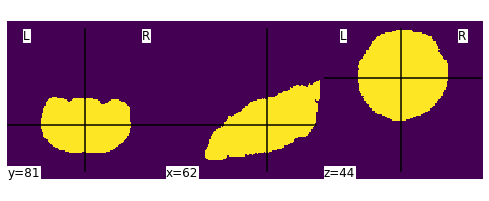

In [23]:
saveMask(dataset_labels[-1], "ground_truth.nii")
nplt.plot_img("ground_truth.nii", cut_coords=[62, 81, 44])

In [24]:
predictions = generateMask(model.predict(X_test))
predictions = predictions.reshape((predictions.shape[0], 128,128,128))

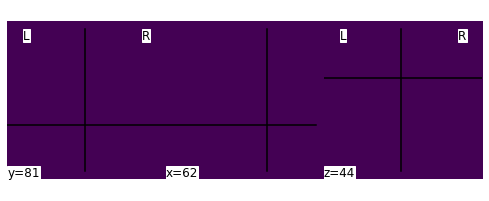

In [25]:
saveMask(predictions[0], "prediction.nii")
nplt.plot_img("prediction.nii", cut_coords=[62, 81, 44])

Ground truth:
Predicted:


RuntimeError: No surface found at the given iso value.

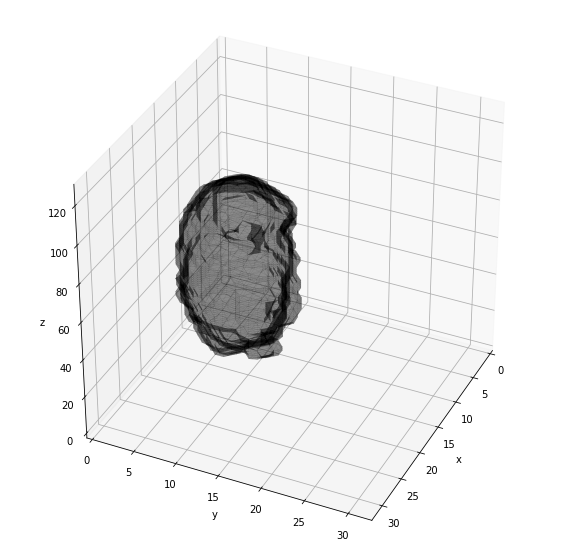

In [26]:
pred = generateMask(model.predict(X_test)[0])
gt   = Y_test[0]

print("Ground truth:")
plot3D_label(gt)

print("Predicted:")
plot3D_label(pred)

# Usefull links

https://github.com/ellisdg/3DUnetCNN

https://www.rmsb.u-bordeaux.fr/nextcloud/index.php/s/6oMjTeDtmREpMgC

https://playground.tensorflow.org